In [1]:
# ============================================================================
# Cell 1: Setup
# ============================================================================
import sys
import os
project_root = os.path.abspath('..')
sys.path.insert(0, project_root)

import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

from src.utils.config_loader import ConfigLoader
from src.data.dataset import ChestXrayDataset

print("✅ Imports OK")
print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")

✅ Imports OK
PyTorch: 2.8.0+cu129
CUDA: True


In [2]:
# ============================================================================
# Cell 2: Load config
# ============================================================================
loader = ConfigLoader(project_root)
data_config = loader.load_data_config()

print("=" * 70)
print("📋 DATA CONFIGURATION")
print("=" * 70)
print(f"Root dir: {data_config['data']['root_dir']}")
print(f"Classes: {data_config['data']['classes']}")
print(f"Image size: {data_config['data']['image_size']}")

# Check if balanced data exists
balanced_exists = Path(data_config['data']['root_dir']).exists()
processed_exists = Path('../data/processed').exists()

print(f"\n📁 Data availability:")
print(f"  Balanced: {'✅' if balanced_exists else '❌'} {data_config['data']['root_dir']}")
print(f"  Processed: {'✅' if processed_exists else '❌'} ../data/processed")

# Choose data source
if balanced_exists:
    DATA_ROOT = data_config['data']['root_dir']
    print(f"\n🎯 Using: BALANCED data")
elif processed_exists:
    DATA_ROOT = '../data/processed'
    print(f"\n⚠️  Using: PROCESSED data (not balanced)")
else:
    raise FileNotFoundError("No data found! Run preprocessing first.")

📋 DATA CONFIGURATION
Root dir: /home/ducluong/chest-xray-classification/data/balanced
Classes: ['COVID-19', 'Normal', 'Pneumonia', 'Tuberculosis']
Image size: 224

📁 Data availability:
  Balanced: ✅ /home/ducluong/chest-xray-classification/data/balanced
  Processed: ✅ ../data/processed

🎯 Using: BALANCED data


In [3]:
# ============================================================================
# Cell 3: Define transforms
# ============================================================================
mean = data_config['data']['normalization']['imagenet']['mean']
std = data_config['data']['normalization']['imagenet']['std']
image_size = data_config['data']['image_size']

print(f"Normalization (ImageNet):")
print(f"  Mean: {mean}")
print(f"  Std:  {std}")

# Training transforms (with augmentation)
train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomRotation(data_config['data']['augmentation']['rotation_degrees']),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(
        brightness=data_config['data']['augmentation']['color_jitter']['brightness'],
        contrast=data_config['data']['augmentation']['color_jitter']['contrast']
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Val/Test transforms (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

print("\n✅ Transforms created")
print("  Train: Resize + Augmentation + Normalize")
print("  Test:  Resize + Normalize only")

Normalization (ImageNet):
  Mean: [0.485, 0.456, 0.406]
  Std:  [0.229, 0.224, 0.225]

✅ Transforms created
  Train: Resize + Augmentation + Normalize
  Test:  Resize + Normalize only


In [4]:
# ============================================================================
# Cell 4: Create datasets
# ============================================================================
train_dataset = ChestXrayDataset(
    root_dir=os.path.join(DATA_ROOT, 'train'),
    transform=train_transform
)

val_dataset = ChestXrayDataset(
    root_dir=os.path.join(DATA_ROOT, 'val'),
    transform=test_transform
)

test_dataset = ChestXrayDataset(
    root_dir=os.path.join(DATA_ROOT, 'test'),
    transform=test_transform
)

print(f"\n✅ Datasets loaded:")
print(f"  Train: {len(train_dataset):,} samples")
print(f"  Val:   {len(val_dataset):,} samples")
print(f"  Test:  {len(test_dataset):,} samples")
print(f"\n  Classes: {train_dataset.classes}")

# Show distribution
print(f"\n📊 Train Distribution:")
train_dist = train_dataset.get_class_distribution()
total = sum(train_dist.values())
for cls, count in train_dist.items():
    pct = (count / total) * 100
    print(f"  {cls:20s}: {count:5d} ({pct:5.2f}%)")

# Calculate balance ratio
counts = list(train_dist.values())
balance_ratio = min(counts) / max(counts)
print(f"\n  Balance ratio: {balance_ratio:.3f} ", end="")
if balance_ratio >= 0.9:
    print("✅ Well balanced!")
elif balance_ratio >= 0.7:
    print("⚠️  Moderately balanced")
else:
    print("❌ Imbalanced")

📂 Detected classes: ['COVID-19', 'Normal', 'Pneumonia', 'Tuberculosis']
✅ Loaded 10000 images from /home/ducluong/chest-xray-classification/data/balanced/train
📂 Detected classes: ['COVID-19', 'Normal', 'Pneumonia', 'Tuberculosis']
✅ Loaded 2500 images from /home/ducluong/chest-xray-classification/data/balanced/val
📂 Detected classes: ['COVID-19', 'Normal', 'Pneumonia', 'Tuberculosis']
✅ Loaded 2500 images from /home/ducluong/chest-xray-classification/data/balanced/test

✅ Datasets loaded:
  Train: 10,000 samples
  Val:   2,500 samples
  Test:  2,500 samples

  Classes: ['COVID-19', 'Normal', 'Pneumonia', 'Tuberculosis']

📊 Train Distribution:
  COVID-19            :  2500 (25.00%)
  Normal              :  2500 (25.00%)
  Pneumonia           :  2500 (25.00%)
  Tuberculosis        :  2500 (25.00%)

  Balance ratio: 1.000 ✅ Well balanced!


In [5]:
# ============================================================================
# Cell 5: Create dataloaders
# ============================================================================
batch_size = 16

train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True,
    num_workers=4, 
    pin_memory=True,
    prefetch_factor=2,
    persistent_workers=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False,
    num_workers=4, 
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False,
    num_workers=4, 
    pin_memory=True
)

print(f"\n✅ DataLoaders (batch_size={batch_size}):")
print(f"  Train: {len(train_loader)} batches")
print(f"  Val:   {len(val_loader)} batches")
print(f"  Test:  {len(test_loader)} batches")


✅ DataLoaders (batch_size=16):
  Train: 625 batches
  Val:   157 batches
  Test:  157 batches


In [6]:
# ============================================================================
# Cell 6: Test loading & verify
# ============================================================================
images, labels = next(iter(train_loader))

print("\n" + "=" * 70)
print("✅ BATCH VERIFICATION")
print("=" * 70)
print(f"Batch shape:  {images.shape}")
print(f"Expected:     torch.Size([{batch_size}, 3, {image_size}, {image_size}])")
print(f"Labels shape: {labels.shape}")
print(f"Label range:  {labels.min().item()} - {labels.max().item()}")

print(f"\nFirst 8 labels: {labels[:8].tolist()}")
for i in range(min(4, len(labels))):
    print(f"  Sample {i}: class={labels[i].item()} ({train_dataset.classes[labels[i]]})")

print(f"\nNormalized stats:")
print(f"  Min:  {images.min():.4f}")
print(f"  Max:  {images.max():.4f}")
print(f"  Mean: {images.mean():.4f} (should be ~0)")
print(f"  Std:  {images.std():.4f} (should be ~1)")

if abs(images.mean()) < 0.2 and abs(images.std()-1) < 0.3:
    print("\n✅ Normalization working correctly!")
else:
    print("\n⚠️  Normalization might be off")


✅ BATCH VERIFICATION
Batch shape:  torch.Size([16, 3, 224, 224])
Expected:     torch.Size([16, 3, 224, 224])
Labels shape: torch.Size([16])
Label range:  0 - 3

First 8 labels: [1, 1, 3, 0, 2, 0, 0, 2]
  Sample 0: class=1 (Normal)
  Sample 1: class=1 (Normal)
  Sample 2: class=3 (Tuberculosis)
  Sample 3: class=0 (COVID-19)

Normalized stats:
  Min:  -2.1179
  Max:  2.6400
  Mean: 0.2949 (should be ~0)
  Std:  1.1962 (should be ~1)

⚠️  Normalization might be off



🖼️  Visualizing training batch:


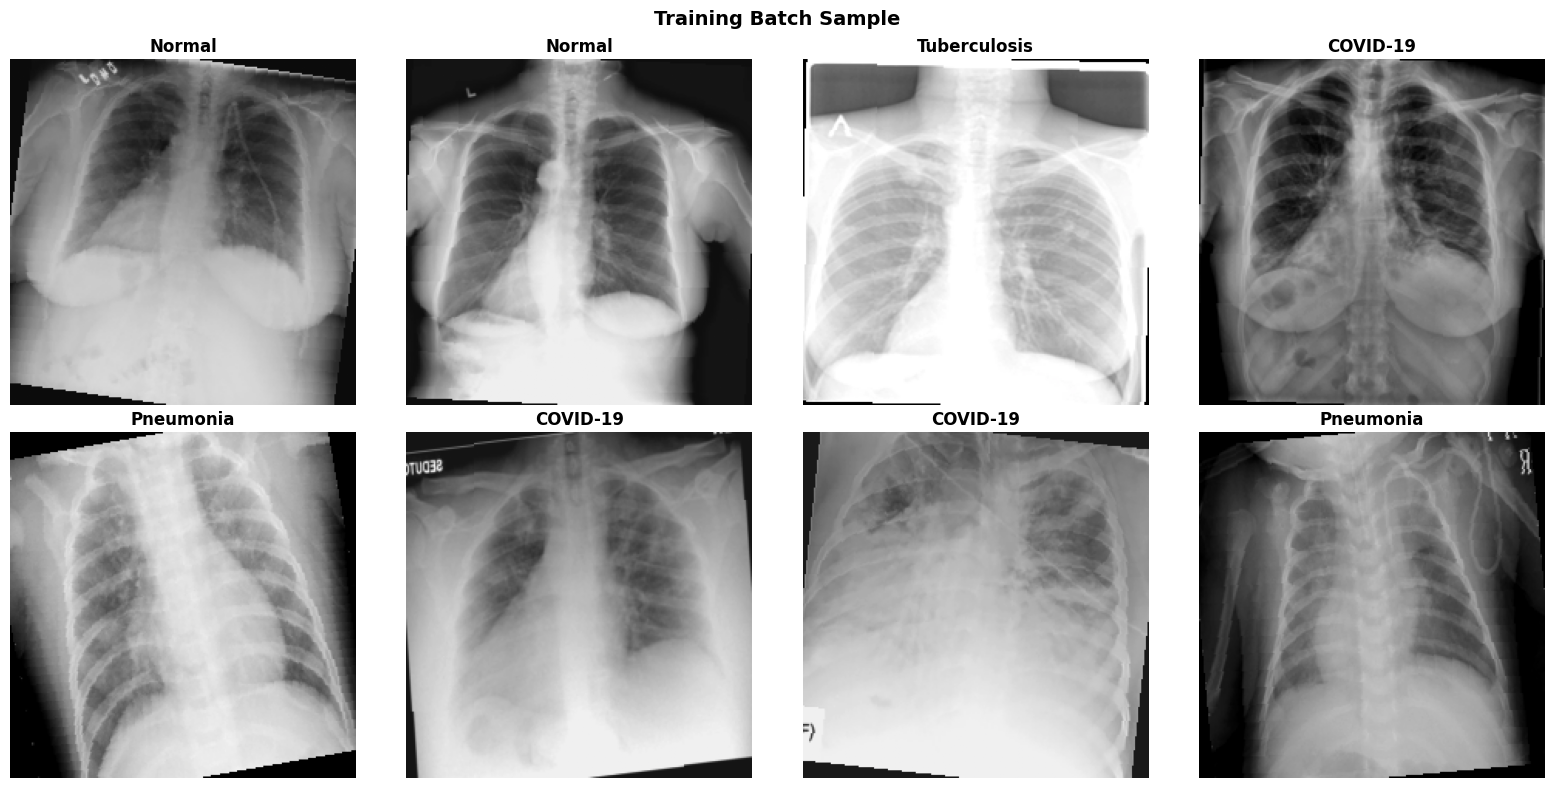

In [7]:
# ============================================================================
# Cell 7: Visualize batch
# ============================================================================
def denormalize(tensor, mean, std):
    """Denormalize image tensor"""
    t = tensor.clone()
    for i, (m, s) in enumerate(zip(mean, std)):
        t[i] = t[i] * s + m
    return t

def show_batch(images, labels, classes, mean, std, n=8):
    """Show batch of images"""
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for i in range(min(n, len(images))):
        img = denormalize(images[i], mean, std)
        img = img.permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        
        axes[i].imshow(img)
        axes[i].set_title(f"{classes[labels[i]]}", fontsize=12, fontweight='bold')
        axes[i].axis('off')
    
    plt.suptitle("Training Batch Sample", fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("\n🖼️  Visualizing training batch:")
show_batch(images, labels, train_dataset.classes, mean, std)

In [8]:
# ============================================================================
# Cell 8: Check distribution in batches
# ============================================================================
from collections import Counter

def check_batch_distribution(loader, n_batches=20):
    """Check class distribution across batches"""
    all_labels = []
    
    for i, (_, labels) in enumerate(loader):
        if i >= n_batches:
            break
        all_labels.extend(labels.tolist())
    
    counts = Counter(all_labels)
    total = len(all_labels)
    
    print(f"\nDistribution in {n_batches} batches ({total} samples):")
    for idx in sorted(counts.keys()):
        cls = train_dataset.classes[idx]
        count = counts[idx]
        pct = count / total * 100
        print(f"  {cls:20s}: {count:4d} ({pct:5.2f}%)")
    
    # Check balance
    count_values = list(counts.values())
    batch_balance = min(count_values) / max(count_values)
    print(f"\nBatch balance ratio: {batch_balance:.3f}")

check_batch_distribution(train_loader)


Distribution in 20 batches (320 samples):
  COVID-19            :   85 (26.56%)
  Normal              :   90 (28.12%)
  Pneumonia           :   74 (23.12%)
  Tuberculosis        :   71 (22.19%)

Batch balance ratio: 0.789


In [9]:
# ============================================================================
# Cell 9: GPU test
# ============================================================================
if torch.cuda.is_available():
    print("\n" + "=" * 70)
    print("🔥 GPU TEST")
    print("=" * 70)
    
    device = torch.device('cuda:0')
    images_gpu = images.to(device)
    labels_gpu = labels.to(device)
    
    print(f"✅ Data moved to: {images_gpu.device}")
    print(f"GPU memory allocated: {torch.cuda.memory_allocated(0)/1024**2:.2f} MB")
    
    # Test forward pass
    import time
    dummy_conv = torch.nn.Conv2d(3, 64, 3, padding=1).to(device)
    
    # Warmup
    _ = dummy_conv(images_gpu)
    torch.cuda.synchronize()
    
    # Actual test
    start = time.time()
    _ = dummy_conv(images_gpu)
    torch.cuda.synchronize()
    elapsed = time.time() - start
    
    print(f"Forward pass: {elapsed*1000:.2f}ms")
    print(f"Throughput: {batch_size/elapsed:.1f} images/s")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    print("\n⚠️  CUDA not available - will use CPU")


🔥 GPU TEST
✅ Data moved to: cuda:0
GPU memory allocated: 9.19 MB
Forward pass: 358.15ms
Throughput: 44.7 images/s
GPU: NVIDIA GeForce RTX 5070 Ti



🎨 Augmentation Examples (same image, different augmentations):


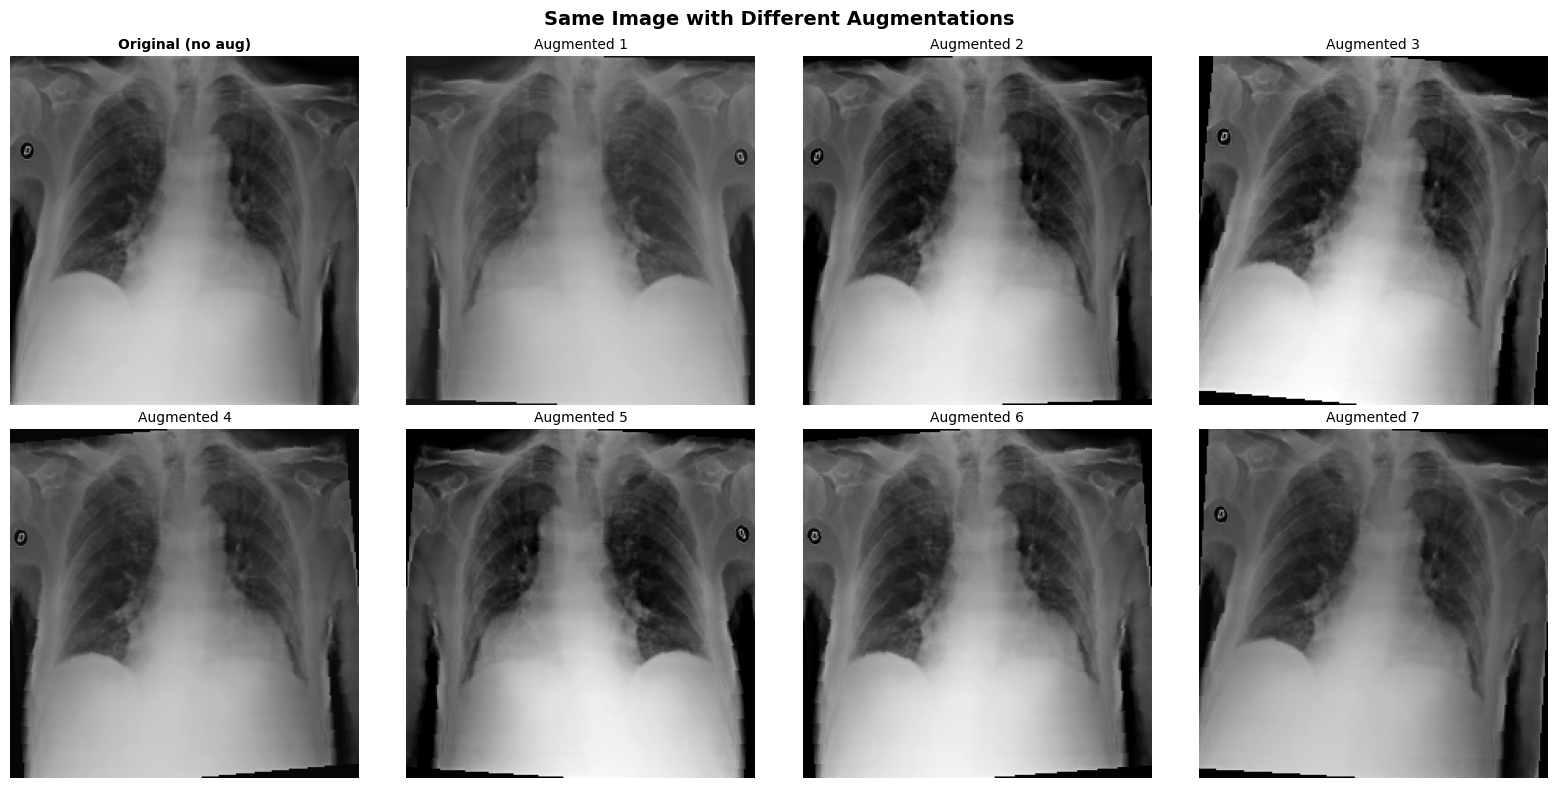

In [10]:
# ============================================================================
# Cell 10: Visualize augmentation variations
# ============================================================================
print("\n🎨 Augmentation Examples (same image, different augmentations):")

# Get one image
original_img_path = train_dataset.samples[0][0]
from PIL import Image
original_img = Image.open(original_img_path).convert('RGB')

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

# Show original
img_tensor = test_transform(original_img)  # No augmentation
img_denorm = denormalize(img_tensor, mean, std)
img_show = img_denorm.permute(1, 2, 0).numpy().clip(0, 1)
axes[0].imshow(img_show)
axes[0].set_title("Original (no aug)", fontsize=10, fontweight='bold')
axes[0].axis('off')

# Show augmented versions
for i in range(1, 8):
    img_tensor = train_transform(original_img)  # With augmentation
    img_denorm = denormalize(img_tensor, mean, std)
    img_show = img_denorm.permute(1, 2, 0).numpy().clip(0, 1)
    
    axes[i].imshow(img_show)
    axes[i].set_title(f"Augmented {i}", fontsize=10)
    axes[i].axis('off')

plt.suptitle("Same Image with Different Augmentations", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [11]:
# ============================================================================
# Cell 11: Summary
# ============================================================================
print("\n" + "=" * 70)
print("📊 DATALOADER TEST SUMMARY")
print("=" * 70)

print(f"\n✅ Data source: {DATA_ROOT}")
print(f"✅ Total samples: {len(train_dataset) + len(val_dataset) + len(test_dataset):,}")
print(f"✅ Classes: {len(train_dataset.classes)}")
print(f"✅ Batch size: {batch_size}")
print(f"✅ Image size: {image_size}x{image_size}")
print(f"✅ Normalization: ImageNet stats")
print(f"✅ Augmentation: Rotation, Flip, ColorJitter")

if torch.cuda.is_available():
    print(f"✅ GPU: Available ({torch.cuda.get_device_name(0)})")
else:
    print(f"⚠️  GPU: Not available (will use CPU)")

print(f"\n{'='*70}")
print("🎯 Ready for training!")
print("=" * 70)


📊 DATALOADER TEST SUMMARY

✅ Data source: /home/ducluong/chest-xray-classification/data/balanced
✅ Total samples: 15,000
✅ Classes: 4
✅ Batch size: 16
✅ Image size: 224x224
✅ Normalization: ImageNet stats
✅ Augmentation: Rotation, Flip, ColorJitter
✅ GPU: Available (NVIDIA GeForce RTX 5070 Ti)

🎯 Ready for training!
